In [1]:
import numpy as np
import preprocessing as pp

from graph import *
from bayesian_decision_evaluation import *
# import importlib
from models.gmm_clf import GMM
from models.logistic_regression_classifier import LogisticRegression, LogisticRegressionWeighted, QuadraticExpansion
from models.svm_classifier import SVMClassifier
from models.svm_kernel_classifier import SVMClassifierPolyKernel, SVMClassifierRBFKernel
from models.multivariate_gaussian_classifier import MultivariateGaussianClassifier, NaiveBayesClassifier, TiedCovarianceClassifier

In [2]:
X, y = utils.load_data()

classes = {
    'Fake': 'blue',
    'Real': 'orange'
}

X_train, y_train, X_test, y_test = utils.split_data(X, y)

In [3]:
def compute_statistics(llr, y_true, prior, unique_labels=None):
    cost_matrix, prior_class_prob, threshold = binary_cost_matrix(prior)
    
    min_DCF, best_threshold = compute_minDCF(llr, y_true, prior, unique_labels)
    y_pred = (llr > threshold) * 1
    y_pred_best = (llr > best_threshold) * 1
    cm = confusion_matrix(y_true, y_pred, unique_labels)
    cm_best = confusion_matrix(y_true, y_pred_best, unique_labels)
    acc = accuracy(cm_best)
    DCF, _, _ = compute_DCF(cm, cost_matrix, prior_class_prob)
    DCF_norm, _, _ = compute_DCF_normalized(cm, cost_matrix, prior_class_prob)
    
    # print(f"MinDCF: {min_DCF:.4f}, DCF: {DCF:.4f}, Normalized DCF: {DCF_norm:.4f}, Accuracy: {acc*100:.2f}%\n")
    
    return min_DCF, DCF, DCF_norm

In [4]:
test_only = True

In [5]:
# dict for storing the minDCF, DCF and DCF_norm for each model
models_performances = {}

### GMM classification

#### Full

In [6]:
n_components = [1, 2, 4, 8, 16, 32]
psiEig = 0.01

In [7]:
covariance_type = 'full'

min_DCF_list_full = []
DCF_norm_list_full = []

for n in n_components:
    print(f"Number of components: {n}")
    model = GMM(n_components=n, covariance_type=covariance_type, psiEig=psiEig)
    folder = f"gmm_{covariance_type}_{n}_components"
    model.fit(X_train, y_train, n_features=2, folder=folder, test_only=test_only)
    score = model.score_binary(X_test)
    min_DCF, DCF, DCF_norm = compute_statistics(score, y_test, prior=0.1, unique_labels=[0, 1])
    min_DCF_list_full.append(min_DCF)
    DCF_norm_list_full.append(DCF_norm)
    models_performances[folder] = {'minDCF': min_DCF, 'DCF': DCF, 'DCF_norm': DCF_norm}

Number of components: 1
GMM 0 loaded successfully.
GMM 1 loaded successfully.
Number of components: 2
GMM 0 loaded successfully.
GMM 1 loaded successfully.
Number of components: 4
GMM 0 loaded successfully.
GMM 1 loaded successfully.
Number of components: 8
GMM 0 loaded successfully.
GMM 1 loaded successfully.
Number of components: 16
GMM 0 loaded successfully.
GMM 1 loaded successfully.
Number of components: 32
GMM 0 loaded successfully.
GMM 1 loaded successfully.


#### Diagonal

In [8]:
covariance_type = 'diagonal'

min_DCF_list_full = []
DCF_norm_list_full = []

for n in n_components:
    print(f"Number of components: {n}")
    model = GMM(n_components=n, covariance_type=covariance_type, psiEig=psiEig)
    folder = f"gmm_{covariance_type}_{n}_components"
    model.fit(X_train, y_train, n_features=2, folder=folder, test_only=test_only)
    score = model.score_binary(X_test)
    min_DCF, DCF, DCF_norm = compute_statistics(score, y_test, prior=0.1, unique_labels=[0, 1])
    min_DCF_list_full.append(min_DCF)
    DCF_norm_list_full.append(DCF_norm)
    models_performances[folder] = {'minDCF': min_DCF, 'DCF': DCF, 'DCF_norm': DCF_norm}

Number of components: 1
GMM 0 loaded successfully.
GMM 1 loaded successfully.
Number of components: 2
GMM 0 loaded successfully.
GMM 1 loaded successfully.
Number of components: 4
GMM 0 loaded successfully.
GMM 1 loaded successfully.
Number of components: 8
GMM 0 loaded successfully.
GMM 1 loaded successfully.
Number of components: 16
GMM 0 loaded successfully.
GMM 1 loaded successfully.
Number of components: 32
GMM 0 loaded successfully.
GMM 1 loaded successfully.


#### Comparison without Calibrations

#### Logistic Regression

In [9]:
lambda_ = np.logspace(-4, 2, 13)
pi = 0.1
X_train, y_train, X_test, y_test = utils.split_data(X, y)
n_T = np.sum(y_train == 1)
n_F = np.sum(y_train == 0)
pEmp = n_T / (n_T + n_F)

##### Logistic Regression non-weighted

In [10]:
for l in lambda_:
    model = LogisticRegression(lambda_=l)
    folder = f"lr_base_raw_data_pi_{pi:.1e}_lambda_{l:.1e}".replace('.', '_').replace('e-0', 'e-')
    model.fit(X_train, y_train, folder=folder, test_only=test_only)
    llr = model.score(X_test) - np.log(pEmp / (1 - pEmp))
    min_DCF, DCF, DCF_norm = compute_statistics(llr, y_test, pi)
    models_performances[folder] = {'minDCF': min_DCF, 'DCF': DCF, 'DCF_norm': DCF_norm}

Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.


#### Logistic Regression weighted

In [11]:
for l in lambda_:
    model = LogisticRegressionWeighted(lambda_=l, pi=pi, n_T=n_T, n_F=n_F)
    folder = f"lr_weighted_raw_data_pi_{pi:.1e}_lambda_{l:.1e}".replace('.', '_').replace('e-0', 'e-')
    model.fit(X_train, y_train, folder=folder, test_only=test_only)
    llr = model.score(X_test) - np.log(pi / (1 - pi))
    min_DCF, DCF, DCF_norm = compute_statistics(llr, y_test, pi)
    models_performances[folder] = {'minDCF': min_DCF, 'DCF': DCF, 'DCF_norm': DCF_norm}

Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.


##### Logistic Regression Quadratic Expansion (non-weighted)

In [12]:
for l in lambda_:
    model = QuadraticExpansion(lambda_=l)
    X_train_quad = model.expand(X_train)
    X_test_quad = model.expand(X_test)
    folder = f"lr_quad_raw_data_pi_{pi:.1e}_lambda_{l:.1e}".replace('.', '_').replace('e-0', 'e-')
    model.fit(X_train_quad, y_train, folder=folder, test_only=test_only)
    llr = model.score(X_test_quad) - np.log(pEmp / (1 - pEmp))
    min_DCF, DCF, DCF_norm = compute_statistics(llr, y_test, pi)
    models_performances[folder] = {'minDCF': min_DCF, 'DCF': DCF, 'DCF_norm': DCF_norm}

Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.


#### Logistic Regression non-weighted with standardization

In [13]:
X_train_std, mean, std = pp.standardize(X_train, return_params=True)
X_test_std = X_test - mean / std

for l in lambda_:
    model = LogisticRegression(lambda_=l)
    folder = f"lr_base_std_data_pi_{pi:.1e}_lambda_{l:.1e}".replace('.', '_').replace('e-0', 'e-')
    model.fit(X_train_std, y_train, folder=folder, test_only=test_only)
    llr = model.score(X_test_std) - np.log(pEmp / (1 - pEmp))
    min_DCF, DCF, DCF_norm = compute_statistics(llr, y_test, pi)
    models_performances[folder] = {'minDCF': min_DCF, 'DCF': DCF, 'DCF_norm': DCF_norm}

Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.


#### Logistic Regression weighted with standardization

In [14]:
for l in lambda_:
    model = LogisticRegressionWeighted(lambda_=l, pi=pi, n_T=n_T, n_F=n_F)
    folder = f"lr_weighted_std_data_pi_{pi:.1e}_lambda_{l:.1e}".replace('.', '_').replace('e-0', 'e-')
    model.fit(X_train_std, y_train, folder=folder, test_only=test_only)
    llr = model.score(X_test_std) - np.log(pi / (1 - pi))
    min_DCF, DCF, DCF_norm = compute_statistics(llr, y_test, pi)
    models_performances[folder] = {'minDCF': min_DCF, 'DCF': DCF, 'DCF_norm': DCF_norm}

Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.
Weights loaded successfully.


#### SVM

##### Linear SVM

In [15]:
K = 1.0
C = np.logspace(-5, 0, 11)
pi = 0.1

In [16]:
for c in C:
    model = SVMClassifier(C=c, K=K)
    folder = f"svm_linear_raw_data_K_{K:.1e}_C_{c:.1e}".replace('.', '_').replace('e-0', 'e-')
    model.fit(X_train, y_train, folder, test_only)
    llr = model.score(X_test)
    min_DCF, DCF, DCF_norm = compute_statistics(llr, y_test, pi)
    models_performances[folder] = {'minDCF': min_DCF, 'DCF': DCF, 'DCF_norm': DCF_norm}

Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.


#### Linear SVM - Centered Data

In [17]:
X_train_std, mean, std = pp.standardize(X_train, return_params=True)
X_test_std = X_test - mean / std

for c in C:
    model = SVMClassifier(C=c, K=K)
    folder = f"svm_linear_std_data_K_{K:.1e}_C_{c:.1e}".replace('.', '_').replace('e-0', 'e-')
    model.fit(X_train_std, y_train, folder, test_only)
    llr = model.score(X_test_std)
    min_DCF, DCF, DCF_norm = compute_statistics(llr, y_test, pi)
    models_performances[folder] = {'minDCF': min_DCF, 'DCF': DCF, 'DCF_norm': DCF_norm}

Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.


#### Kernel SVM - Polynomial

In [18]:
d = 2
c = 1
eps = 0

In [19]:
for ci in C:
    model = SVMClassifierPolyKernel(C=ci, eps=eps, degree=d, delta=c)
    folder = f"svm_poly_raw_data_degree_{d}_delta_{c}_eps_{eps}_C_{ci:.1e}".replace('.', '_').replace('e-0', 'e-')
    model.fit(X_train, y_train, folder, test_only)
    llr = model.score(X_test)
    min_DCF, DCF, DCF_norm = compute_statistics(llr, y_test, pi)
    models_performances[folder] = {'minDCF': min_DCF, 'DCF': DCF, 'DCF_norm': DCF_norm}

Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.


#### Kernel SVM - RBF

In [20]:
eps = 1.0
gamma = [1e-4, 1e-3, 1e-2, 1e-1]
C = np.logspace(-3, 2, 11)

In [21]:
for g in gamma:
    for c in C:
        model = SVMClassifierRBFKernel(C=c, gamma=g, eps=eps)
        folder = f"svm_rbf_raw_data_gamma_{g:.1e}_eps_{eps}_C_{c:.1e}".replace('.', '_').replace('e-0', 'e-')
        model.fit(X_train, y_train, folder, test_only)
        llr = model.score(X_test)
        min_DCF, DCF, DCF_norm = compute_statistics(llr, y_test, pi)
        models_performances[folder] = {'minDCF': min_DCF, 'DCF': DCF, 'DCF_norm': DCF_norm}

Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
Model loaded successfully.
M

In [22]:
print(f"number of models: {len(models_performances)}")

number of models: 154


In [40]:
for model, performance in models_performances.items():
    print(f"Model: {model}")
    for key, value in performance.items():
        print(f"\t{key}: {value:.4f}")

Model: gmm_full_1_components
	minDCF: 0.2629
	DCF: 0.0305
	DCF_norm: 0.3051
Model: gmm_full_2_components
	minDCF: 0.2160
	DCF: 0.0234
	DCF_norm: 0.2337
Model: gmm_full_4_components
	minDCF: 0.2161
	DCF: 0.0240
	DCF_norm: 0.2395
Model: gmm_full_8_components
	minDCF: 0.1786
	DCF: 0.0193
	DCF_norm: 0.1928
Model: gmm_full_16_components
	minDCF: 0.1631
	DCF: 0.0177
	DCF_norm: 0.1766
Model: gmm_full_32_components
	minDCF: 0.2337
	DCF: 0.0250
	DCF_norm: 0.2499
Model: gmm_diagonal_1_components
	minDCF: 0.2570
	DCF: 0.0302
	DCF_norm: 0.3022
Model: gmm_diagonal_2_components
	minDCF: 0.2489
	DCF: 0.0267
	DCF_norm: 0.2674
Model: gmm_diagonal_4_components
	minDCF: 0.1481
	DCF: 0.0169
	DCF_norm: 0.1687
Model: gmm_diagonal_8_components
	minDCF: 0.1463
	DCF: 0.0181
	DCF_norm: 0.1809
Model: gmm_diagonal_16_components
	minDCF: 0.1622
	DCF: 0.0177
	DCF_norm: 0.1769
Model: gmm_diagonal_32_components
	minDCF: 0.1766
	DCF: 0.0199
	DCF_norm: 0.1989
Model: lr_base_raw_data_pi_1_0e-1_lambda_1_0e-4
	minDCF: 0.3

In [23]:
# find the model with the lowest minDCF
minDCF = np.inf
best_model = None
for model, performance in models_performances.items():
    if performance['minDCF'] < minDCF:
        minDCF = performance['minDCF']
        best_model = model
    # print(f"{model}: MinDCF: {performance['minDCF']:.4f}, DCF: {performance['DCF']:.4f}, Normalized DCF: {performance['DCF_norm']:.4f}")

print(f"Best model: {best_model}, MinDCF: {minDCF:.4f}")

Best model: gmm_diagonal_8_components, MinDCF: 0.1463


In [24]:
# find for each model the best configuration
def find_best_configuration(models_performances):
    best_models = {}
    models_type = set([model.split('_')[0] for model in models_performances.keys()])

    for model_type in models_type:
        minDCF = np.inf
        best_model = None
        for model, performance in models_performances.items():
            if model_type in model:
                if performance['minDCF'] < minDCF:
                    minDCF = performance['minDCF']
                    best_model = model
        best_models[best_model] = minDCF

    return best_models

best_models = find_best_configuration(models_performances)
    
for model, minDCF in best_models.items():
    print(f"{model}: MinDCF: {minDCF:.4f}")

svm_rbf_raw_data_gamma_1_0e-1_eps_1_0_C_1_0e+02: MinDCF: 0.1845
lr_quad_raw_data_pi_1_0e-1_lambda_3_2e-2: MinDCF: 0.2436
gmm_diagonal_8_components: MinDCF: 0.1463


### Try different application for the three best models

In [25]:
def compute_statistics(llr, y_true, prior, unique_labels=None, graph=True):
    cost_matrix, prior_class_prob, threshold = binary_cost_matrix(prior)
    
    min_DCF, best_threshold = compute_minDCF(llr, y_true, prior, unique_labels)
    y_pred = (llr > threshold) * 1
    y_pred_best = (llr > best_threshold) * 1
    cm = confusion_matrix(y_true, y_pred, unique_labels)
    cm_best = confusion_matrix(y_true, y_pred_best, unique_labels)
    acc = accuracy(cm_best)
    DCF, _, _ = compute_DCF(cm, cost_matrix, prior_class_prob)
    DCF_norm, _, _ = compute_DCF_normalized(cm, cost_matrix, prior_class_prob)
    
    print(f"MinDCF: {min_DCF:.4f}, DCF: {DCF:.4f}, Normalized DCF: {DCF_norm:.4f}, Accuracy: {acc*100:.2f}%\n")
    if graph:
        plot_bayes_error(llr, y_true, unique_labels)
        
    return min_DCF, DCF, DCF_norm

#### Best model for GMM: GMM - diagonal 8 components

In [26]:
covariance_type = 'diagonal'
n_best_components = 8
prior = 0.1

model = GMM(n_components=n_best_components, covariance_type=covariance_type, psiEig=psiEig)
folder = f"gmm_{covariance_type}_{n_best_components}_components"
model.fit(X_train, y_train, n_features=2, folder=folder, test_only=test_only)
score = model.score_binary(X_test)
min_DCF, _, DCF_norm = compute_statistics(score, y_test, prior=prior, unique_labels=[0, 1], graph=False)

GMM 0 loaded successfully.
GMM 1 loaded successfully.
MinDCF: 0.1463, DCF: 0.0181, Normalized DCF: 0.1809, Accuracy: 93.85%



In [27]:
prior = 0.5

model = GMM(n_components=n_best_components, covariance_type=covariance_type, psiEig=psiEig)
folder = f"gmm_{covariance_type}_{n_best_components}_components"
model.fit(X_train, y_train, n_features=2, folder=folder, test_only=test_only)
score = model.score_binary(X_test)
min_DCF, _, DCF_norm = compute_statistics(score, y_test, prior=prior, unique_labels=[0, 1], graph=False)

GMM 0 loaded successfully.
GMM 1 loaded successfully.
MinDCF: 0.0619, DCF: 0.0346, Normalized DCF: 0.0691, Accuracy: 96.90%



GMM 0 loaded successfully.
GMM 1 loaded successfully.
MinDCF: 0.1577, DCF: 0.0167, Normalized DCF: 0.1668, Accuracy: 93.75%



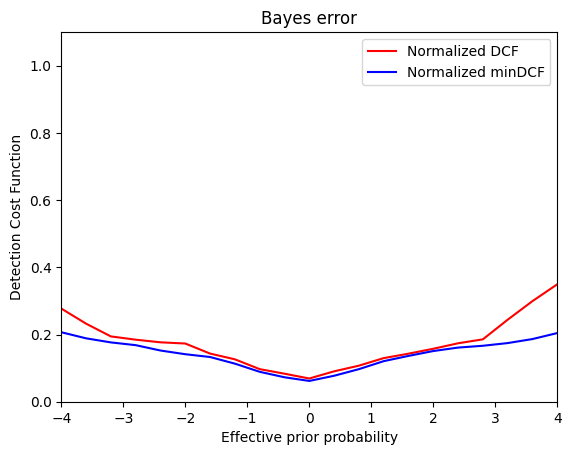

In [28]:
prior = 0.9

model = GMM(n_components=n_best_components, covariance_type=covariance_type, psiEig=psiEig)
folder = f"gmm_{covariance_type}_{n_best_components}_components"
model.fit(X_train, y_train, n_features=2, folder=folder, test_only=test_only)
score = model.score_binary(X_test)
min_DCF, _, DCF_norm = compute_statistics(score, y_test, prior=prior, unique_labels=[0, 1], graph=True)

#### Best model for SVM: SVM - RBF with gamma = 0.1, epsilon = 1.0, C = 100.0

In [29]:
eps = 1.0
gamma = 1e-1
C = 100.0
prior = 0.1

In [30]:
prior = 0.1

model = SVMClassifierRBFKernel(C=C, gamma=gamma, eps=eps)
folder = f"svm_rbf_raw_data_gamma_{gamma:.1e}_eps_{eps}_C_{C:.1e}".replace('.', '_').replace('e-0', 'e-')
model.fit(X_train, y_train, folder, test_only)
llr = model.score(X_test)
min_DCF, DCF, DCF_norm = compute_statistics(llr, y_test, prior=prior, unique_labels=[0, 1], graph=False)

Model loaded successfully.
MinDCF: 0.1845, DCF: 0.0358, Normalized DCF: 0.3581, Accuracy: 93.55%



In [31]:
prior = 0.5

model = SVMClassifierRBFKernel(C=C, gamma=gamma, eps=eps)
folder = f"svm_rbf_raw_data_gamma_{gamma:.1e}_eps_{eps}_C_{C:.1e}".replace('.', '_').replace('e-0', 'e-')
model.fit(X_train, y_train, folder, test_only)
llr = model.score(X_test)
min_DCF, DCF, DCF_norm = compute_statistics(llr, y_test, prior=prior, unique_labels=[0, 1], graph=False)

Model loaded successfully.
MinDCF: 0.0861, DCF: 0.0450, Normalized DCF: 0.0900, Accuracy: 95.70%



Model loaded successfully.
MinDCF: 0.2398, DCF: 0.0437, Normalized DCF: 0.4369, Accuracy: 91.25%



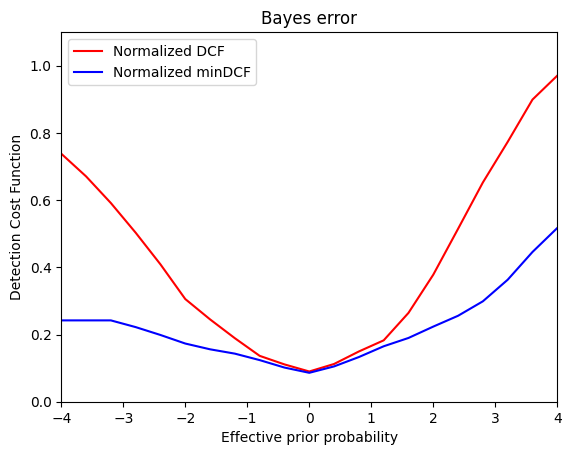

In [32]:
prior = 0.9

model = SVMClassifierRBFKernel(C=C, gamma=gamma, eps=eps)
folder = f"svm_rbf_raw_data_gamma_{gamma:.1e}_eps_{eps}_C_{C:.1e}".replace('.', '_').replace('e-0', 'e-')
model.fit(X_train, y_train, folder, test_only)
llr = model.score(X_test)
min_DCF, DCF, DCF_norm = compute_statistics(llr, y_test, prior=prior, unique_labels=[0, 1], graph=True)

#### Best model for Logistic Regression: Quadratic Expansion with lambda = 0.032, pi = 0.1

In [33]:
l = 0.032
pi = 0.1

model = QuadraticExpansion(lambda_=l)
X_train_quad = model.expand(X_train)
X_test_quad = model.expand(X_test)
folder = f"lr_quad_raw_data_pi_{pi:.1e}_lambda_{l:.1e}".replace('.', '_').replace('e-0', 'e-')
model.fit(X_train_quad, y_train, folder=folder, test_only=test_only)
llr = model.score(X_test_quad) - np.log(pEmp / (1 - pEmp))
min_DCF, DCF, DCF_norm = compute_statistics(llr, y_test, pi, unique_labels=[0, 1], graph=False)

Weights loaded successfully.
MinDCF: 0.2436, DCF: 0.0497, Normalized DCF: 0.4972, Accuracy: 89.35%



In [34]:
pi = 0.5

model = QuadraticExpansion(lambda_=l)
X_train_quad = model.expand(X_train)
X_test_quad = model.expand(X_test)
folder = f"lr_quad_raw_data_pi_{pi:.1e}_lambda_{l:.1e}".replace('.', '_').replace('e-0', 'e-')
model.fit(X_train_quad, y_train, folder=folder, test_only=test_only)
llr = model.score(X_test_quad) - np.log(pEmp / (1 - pEmp))
min_DCF, DCF, DCF_norm = compute_statistics(llr, y_test, pi, unique_labels=[0, 1], graph=False)

Weights loaded successfully.
MinDCF: 0.1130, DCF: 0.0594, Normalized DCF: 0.1188, Accuracy: 94.35%



Weights loaded successfully.
MinDCF: 0.3119, DCF: 0.0499, Normalized DCF: 0.4986, Accuracy: 88.85%



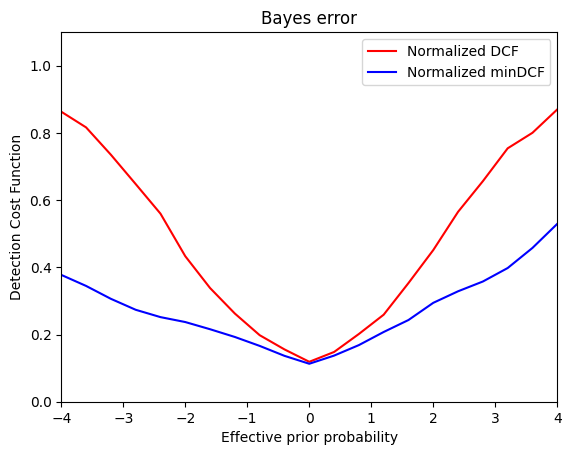

In [35]:
pi = 0.9

model = QuadraticExpansion(lambda_=l)
X_train_quad = model.expand(X_train)
X_test_quad = model.expand(X_test)
folder = f"lr_quad_raw_data_pi_{pi:.1e}_lambda_{l:.1e}".replace('.', '_').replace('e-0', 'e-')
model.fit(X_train_quad, y_train, folder=folder, test_only=test_only)
llr = model.score(X_test_quad) - np.log(pEmp / (1 - pEmp))
min_DCF, DCF, DCF_norm = compute_statistics(llr, y_test, pi, unique_labels=[0, 1], graph=True)